# 3. Huấn Luyện Mô Hình với Train/Test Đã Chia

- Train trên tập train đã augment
- Validate trên một phần của train (train/val split)
- **Test cuối cùng trên test set gốc (KHÔNG augment)**

Đảm bảo test set hoàn toàn độc lập và không bị leak!

## 3.1. Import Thư Viện

In [ ]:
import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

print('Đã import thành công các thư viện!')

Đã import thành công các thư viện!


## 3.2. Cấu Hình

In [ ]:
# Tham số huấn luyện - PHASE 1 IMPROVEMENTS
BATCH_SIZE = 128
EPOCHS = 40  # Tăng từ 20 -> 40
LEARNING_RATE = 5e-4
EMBED_DIM = 256  # Tăng từ 128 -> 256
HIDDEN_DIM = 256  # Tăng từ 128 -> 256
DROPOUT = 0.35
WEIGHT_DECAY = 1e-4
GRADIENT_CLIP = 0.5
LABEL_SMOOTHING = 0.1
VAL_SIZE = 0.15
EARLY_STOP_PATIENCE = 8  # Tăng từ 5 -> 8
CAP_LEN = 256
SEED = 42

# Đường dẫn
DATA_DIR = '/kaggle/input/my-sentiment-dataset'
TRAIN_X_PATH = os.path.join(DATA_DIR, 'train_encoded_texts.npy')
TRAIN_Y_PATH = os.path.join(DATA_DIR, 'train_encoded_labels.npy')
TEST_X_PATH = os.path.join(DATA_DIR, 'test_encoded_texts.npy')
TEST_Y_PATH = os.path.join(DATA_DIR, 'test_encoded_labels.npy')
WORD2IDX_PATH = os.path.join(DATA_DIR, 'word2idx.json')
LABEL2IDX_PATH = os.path.join(DATA_DIR, 'label2idx.json')
IDX2LABEL_PATH = os.path.join(DATA_DIR, 'idx2label.json')
METADATA_PATH = os.path.join(DATA_DIR, 'metadata.json')

OUT_DIR = '/kaggle/working/outputs_split'
os.makedirs(OUT_DIR, exist_ok=True)

# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

print(f'Seed: {SEED}')
print(f'Output directory: {OUT_DIR}')
print(f'Data directory: {DATA_DIR}')
print(f'\nPHASE 1 IMPROVEMENTS:')
print(f'   - Embed dim: 128 → {EMBED_DIM}')
print(f'   - Hidden dim: 128 → {HIDDEN_DIM}')
print(f'   - Epochs: 20 → {EPOCHS}')
print(f'   - Patience: 5 → {EARLY_STOP_PATIENCE}')


Seed: 42
Output directory: /kaggle/working/outputs_split
Data directory: /kaggle/input/my-sentiment-dataset

PHASE 1 IMPROVEMENTS:
   - Embed dim: 128 → 256
   - Hidden dim: 128 → 256
   - Epochs: 20 → 40
   - Patience: 5 → 8


## 3.3. Load Metadata và Mappings

In [ ]:
print('Đang load metadata và mappings...\n')

# Load metadata
with open(METADATA_PATH, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

print('Dataset info:')
print(f"   Train samples: {metadata['dataset_info']['train_samples']} (augmented)")
print(f"   Test samples: {metadata['dataset_info']['test_samples']} (original)")
print(f"   Num classes: {metadata['dataset_info']['num_classes']}")
print(f"   Vocab size: {metadata['vocab_stats']['vocab_size']}")
print(f"   Test UNK rate: {metadata['vocab_stats']['test_unk_rate']:.2f}%")

# Load mappings
with open(WORD2IDX_PATH, 'r', encoding='utf-8') as f:
    word2idx = json.load(f)

with open(LABEL2IDX_PATH, 'r', encoding='utf-8') as f:
    label2idx = json.load(f)

with open(IDX2LABEL_PATH, 'r', encoding='utf-8') as f:
    idx2label = json.load(f)

print(f'\nMappings loaded')
print(f'   Vocab size: {len(word2idx):,}')
print(f'   Label mapping: {label2idx}')

Đang load metadata và mappings...

Dataset info:
   Train samples: 59995 (augmented)
   Test samples: 10000 (original)
   Num classes: 2
   Vocab size: 50002
   Test UNK rate: 0.86%

Mappings loaded
   Vocab size: 50,002
   Label mapping: {'negative': 0, 'positive': 1}


## 3.4. Load Train và Test Data

In [ ]:
print('Đang load encoded data...\n')

# Load train (đã augment)
train_X = np.load(TRAIN_X_PATH, allow_pickle=True)
train_y = np.load(TRAIN_Y_PATH, allow_pickle=True)

print(f'Train set loaded (đã augment):')
print(f'   X shape: {train_X.shape}')
print(f'   y shape: {train_y.shape}')
print(f'   Samples: {len(train_X):,}')

# Load test (KHÔNG augment)
test_X = np.load(TEST_X_PATH, allow_pickle=True)
test_y = np.load(TEST_Y_PATH, allow_pickle=True)

print(f'\nTest set loaded (KHÔNG augment):')
print(f'   X shape: {test_X.shape}')
print(f'   y shape: {test_y.shape}')
print(f'   Samples: {len(test_X):,}')

# Thống kê phân phối
from collections import Counter
print(f'\nPhân phối nhãn train:')
for label, count in sorted(Counter(train_y).items()):
    pct = count / len(train_y) * 100
    print(f'   Label {label}: {count:,} ({pct:.1f}%)')

print(f'\nPhân phối nhãn test:')
for label, count in sorted(Counter(test_y).items()):
    pct = count / len(test_y) * 100
    print(f'   Label {label}: {count:,} ({pct:.1f}%)')

Đang load encoded data...

Train set loaded (đã augment):
   X shape: (59995,)
   y shape: (59995,)
   Samples: 59,995

Test set loaded (KHÔNG augment):
   X shape: (10000,)
   y shape: (10000,)
   Samples: 10,000

Phân phối nhãn train:
   Label 0: 29,997 (50.0%)
   Label 1: 29,998 (50.0%)

Phân phối nhãn test:
   Label 0: 5,000 (50.0%)
   Label 1: 5,000 (50.0%)


## 3.5. Chuẩn Bị Dữ Liệu

In [ ]:
# Chuyển đổi dữ liệu
def to_list_of_lists(X):
    """Chuyển đổi X thành list of lists"""
    if isinstance(X, np.ndarray):
        if X.dtype == object:
            return [list(map(int, s)) for s in X.tolist()]
        else:
            return [list(s) for s in X]
    return X

train_seqs = to_list_of_lists(train_X)
train_y = np.array(train_y, dtype=np.int64).reshape(-1)

test_seqs = to_list_of_lists(test_X)
test_y = np.array(test_y, dtype=np.int64).reshape(-1)

print(f'Data converted')
print(f'   Train sequences: {len(train_seqs):,}')
print(f'   Test sequences: {len(test_seqs):,}')

Data converted
   Train sequences: 59,995
   Test sequences: 10,000


## 3.6. Thống Kê Độ Dài

In [ ]:
train_lengths = np.array([len(s) for s in train_seqs])
test_lengths = np.array([len(s) for s in test_seqs])

print('Thống kê độ dài sequences:\n')
print('Train:')
print(f'   Min: {train_lengths.min()}, Max: {train_lengths.max()}')
print(f'   Mean: {train_lengths.mean():.1f}, Median: {np.median(train_lengths):.0f}')
print(f'   P95: {np.percentile(train_lengths, 95):.0f}')

print('\nTest:')
print(f'   Min: {test_lengths.min()}, Max: {test_lengths.max()}')
print(f'   Mean: {test_lengths.mean():.1f}, Median: {np.median(test_lengths):.0f}')
print(f'   P95: {np.percentile(test_lengths, 95):.0f}')

# Chọn max_len
max_len = min(int(np.percentile(train_lengths, 95)), CAP_LEN)
max_len = max(8, max_len)
print(f'\nMax length: {max_len}')

📏 Thống kê độ dài sequences:

Train:
   Min: 1, Max: 2485
   Mean: 183.9, Median: 128
   P95: 516

Test:
   Min: 6, Max: 2151
   Mean: 233.2, Median: 175
   P95: 597

Max length: 256


## 3.7. Padding và Tạo Datasets

In [ ]:
# Lấy pad_idx
pad_idx = word2idx.get('<PAD>', 0)
vocab_size = len(word2idx)

print(f'Vocab info:')
print(f'   Vocab size: {vocab_size:,}')
print(f'   PAD index: {pad_idx}')

# Padding function
def pad_and_truncate(seqs, max_len, pad_value=0):
    """Padding và truncate sequences"""
    N = len(seqs)
    out = np.full((N, max_len), pad_value, dtype=np.int64)
    lengths = np.zeros(N, dtype=np.int64)
    
    for i, s in enumerate(seqs):
        L = min(len(s), max_len)
        if L > 0:
            out[i, :L] = np.array(s[:L], dtype=np.int64)
        lengths[i] = L
    
    return torch.from_numpy(out), torch.from_numpy(lengths)

# Dataset class
class SeqDataset(Dataset):
    def __init__(self, padded, lengths, labels):
        self.padded = padded
        self.lengths = lengths
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.padded[idx],
            'length': self.lengths[idx],
            'label': self.labels[idx]
        }

print('\nĐã định nghĩa SeqDataset')

Vocab info:
   Vocab size: 50,002
   PAD index: 0

Đã định nghĩa SeqDataset


## 3.8. Chia Train/Val và Tạo DataLoaders

In [ ]:
print(f'Chia train/val ({100*(1-VAL_SIZE):.0f}%/{100*VAL_SIZE:.0f}%)...\n')

# Chia train thành train/val
X_train, X_val, y_train, y_val = train_test_split(
    train_seqs, train_y, 
    test_size=VAL_SIZE, 
    random_state=SEED, 
    stratify=train_y
)

print(f'Data split:')
print(f'   Train: {len(X_train):,} samples')
print(f'   Val: {len(X_val):,} samples')
print(f'   Test: {len(test_seqs):,} samples (KHÔNG augment)')

# Padding
print(f'\nPadding sequences (max_len={max_len})...')
pad_train, len_train = pad_and_truncate(X_train, max_len, pad_value=pad_idx)
pad_val, len_val = pad_and_truncate(X_val, max_len, pad_value=pad_idx)
pad_test, len_test = pad_and_truncate(test_seqs, max_len, pad_value=pad_idx)

print(f'   Train: {pad_train.shape}')
print(f'   Val: {pad_val.shape}')
print(f'   Test: {pad_test.shape}')

# Tạo datasets
ds_train = SeqDataset(pad_train, len_train, y_train)
ds_val = SeqDataset(pad_val, len_val, y_val)
ds_test = SeqDataset(pad_test, len_test, test_y)

# Tạo dataloaders
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

print(f'\nDataLoaders created:')
print(f'   Train batches: {len(train_loader)}')
print(f'   Val batches: {len(val_loader)}')
print(f'   Test batches: {len(test_loader)}')

Chia train/val (85%/15%)...

Data split:
   Train: 50,995 samples
   Val: 9,000 samples
   Test: 10,000 samples (KHÔNG augment)

Padding sequences (max_len=256)...
   Train: torch.Size([50995, 256])
   Val: torch.Size([9000, 256])
   Test: torch.Size([10000, 256])

DataLoaders created:
   Train batches: 399
   Val batches: 71
   Test batches: 79


## 3.9. Định Nghĩa Model

In [ ]:
class BiLSTMClassifier(nn.Module):
    """BiLSTM Classifier với multi-pooling"""
    
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=3, pad_idx=0, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2 * 3, num_classes)  # 3 pooling strategies
    
    def forward(self, input_ids, lengths):
        emb = self.embedding(input_ids)
        
        lengths_cpu = lengths.cpu()
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths_cpu, batch_first=True, enforce_sorted=False
        )
        
        packed_out, (h_n, c_n) = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        
        B, T, D = out.shape
        
        # Create mask
        mask = torch.arange(T, device=out.device).unsqueeze(0).expand(B, -1) < lengths.unsqueeze(1)
        mask = mask.unsqueeze(-1).float()
        
        # Max pooling
        out_masked = out.clone()
        out_masked[mask.squeeze(-1) == 0] = -1e9
        max_pool, _ = torch.max(out_masked, dim=1)
        
        # Mean pooling
        sum_pool = (out * mask).sum(dim=1)
        lengths_clamped = lengths.clamp(min=1).unsqueeze(-1).float()
        mean_pool = sum_pool / lengths_clamped
        
        # Last hidden states
        last_states = torch.cat([h_n[-2], h_n[-1]], dim=1)
        
        # Combine
        features = torch.cat([max_pool, mean_pool, last_states], dim=1)
        
        logits = self.fc(self.dropout(features))
        return logits

# Khởi tạo model
num_classes = len(label2idx)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BiLSTMClassifier(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=num_classes,
    pad_idx=pad_idx,
    dropout=DROPOUT
).to(device)

print(f'Model initialized on {device}')
print(f'   Parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'\nArchitecture:')
print(model)

Model initialized on cuda
   Parameters: 13,856,258

Architecture:
BiLSTMClassifier(
  (embedding): Embedding(50002, 256, padding_idx=0)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (fc): Linear(in_features=1536, out_features=2, bias=True)
)


## 3.10. Training Setup

In [ ]:
# Optimizer với weight decay (L2 regularization)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning Rate Scheduler - tự động giảm LR khi val F1 không cải thiện
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',  # Maximize val F1
    factor=0.5,  # Giảm LR xuống 50%
    patience=3,  # Đợi 3 epochs không cải thiện
    min_lr=1e-6
)

# Compute class weights để xử lý imbalanced data
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_y), 
    y=train_y
)
class_weights = torch.FloatTensor(class_weights).to(device)

# Loss function với class weights và label smoothing
criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=LABEL_SMOOTHING
)

print('Training setup:')
print(f'   Loss: CrossEntropyLoss with class weights & label smoothing ({LABEL_SMOOTHING})')
print(f'   Optimizer: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})')
print(f'   Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)')
print(f'   Class weights: {class_weights.cpu().numpy()}')
print(f'   Dropout: {DROPOUT}')
print(f'   Gradient clipping: {GRADIENT_CLIP}')
print(f'   Early stopping patience: {EARLY_STOP_PATIENCE}')


Training setup:
   Loss: CrossEntropyLoss with class weights & label smoothing (0.1)
   Optimizer: Adam (lr=0.0005, weight_decay=0.0001)
   Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)
   Class weights: [1.0000167 0.9999833]
   Dropout: 0.35
   Gradient clipping: 0.5
   Early stopping patience: 8


## 3.11. Evaluation Function

In [ ]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    """Đánh giá model"""
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    
    for batch in data_loader:
        ids = batch['input_ids'].to(device)
        lens = batch['length'].to(device)
        labels = batch['label'].to(device)
        
        logits = model(ids, lens)
        loss = criterion(logits, labels)
        total_loss += loss.item()
        
        preds = torch.argmax(logits, dim=1)
        
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    avg_loss = total_loss / len(data_loader)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    report = classification_report(all_labels, all_preds, digits=4)
    
    return avg_loss, macro_f1, report, all_preds, all_labels

print('Evaluation function defined')

Evaluation function defined


## 3.12. Training Loop

In [ ]:
best_f1 = -1.0
wait = 0
best_path = os.path.join(OUT_DIR, 'best_model.pt')
history = []

print('\n' + '='*80)
print('BẮT ĐẦU HUẤN LUYỆN - PHASE 1 IMPROVEMENTS')
print('='*80)
print(f'Train: {len(ds_train):,} samples (augmented)')
print(f'Val: {len(ds_val):,} samples (augmented)')
print(f'Test: {len(ds_test):,} samples (KHÔNG augment - chưa sử dụng)')
print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')
print('='*80 + '\n')

for epoch in range(1, EPOCHS + 1):
    # Training
    model.train()
    total_loss = 0.0
    
    for batch in train_loader:
        ids = batch['input_ids'].to(device)
        lens = batch['length'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        logits = model(ids, lens)
        loss = criterion(logits, labels)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP)
        optimizer.step()
        
        total_loss += loss.item()
    
    train_loss = total_loss / len(train_loader)
    val_loss, val_f1, _, _, _ = evaluate(model, val_loader, device)
    
    # Learning rate scheduling - giảm LR khi val F1 không cải thiện
    scheduler.step(val_f1)
    current_lr = optimizer.param_groups[0]['lr']
    
    history.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_macro_f1': val_f1,
        'lr': current_lr
    })
    
    print(f'Epoch {epoch:02d}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | LR: {current_lr:.2e}', end='')
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        wait = 0
        torch.save({
            'model_state': model.state_dict(),
            'best_val_macro_f1': best_f1,
            'epoch': epoch,
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict()
        }, best_path)
        print(f' >>> Saved (F1: {best_f1:.4f})')
    else:
        wait += 1
        print(f' (patience: {wait}/{EARLY_STOP_PATIENCE})')
        
        if wait >= EARLY_STOP_PATIENCE:
            print(f'\nEarly stopping at epoch {epoch}!')
            break

print('\n' + '='*80)
print('TRAINING COMPLETED!')
print(f'Best Val F1: {best_f1:.4f} at epoch {ckpt.get("epoch", "N/A") if "ckpt" in dir() else "will be loaded"}')
print('='*80)



BẮT ĐẦU HUẤN LUYỆN - PHASE 1 IMPROVEMENTS
Train: 50,995 samples (augmented)
Val: 9,000 samples (augmented)
Test: 10,000 samples (KHÔNG augment - chưa sử dụng)
Model parameters: 13,856,258

Epoch 01/40 | Train Loss: 0.5402 | Val Loss: 0.4672 | Val F1: 0.8193 | LR: 5.00e-04 >>> 💾 Saved (F1: 0.8193)
Epoch 02/40 | Train Loss: 0.4445 | Val Loss: 0.4279 | Val F1: 0.8516 | LR: 5.00e-04 >>> 💾 Saved (F1: 0.8516)
Epoch 03/40 | Train Loss: 0.4118 | Val Loss: 0.4396 | Val F1: 0.8402 | LR: 5.00e-04 (patience: 1/8)
Epoch 04/40 | Train Loss: 0.3946 | Val Loss: 0.4200 | Val F1: 0.8571 | LR: 5.00e-04 >>> 💾 Saved (F1: 0.8571)
Epoch 05/40 | Train Loss: 0.3879 | Val Loss: 0.4122 | Val F1: 0.8599 | LR: 5.00e-04 >>> 💾 Saved (F1: 0.8599)
Epoch 06/40 | Train Loss: 0.3895 | Val Loss: 0.4211 | Val F1: 0.8592 | LR: 5.00e-04 (patience: 1/8)
Epoch 07/40 | Train Loss: 0.3870 | Val Loss: 0.4481 | Val F1: 0.8459 | LR: 5.00e-04 (patience: 2/8)
Epoch 08/40 | Train Loss: 0.3892 | Val Loss: 0.4199 | Val F1: 0.8586 | LR:

## 3.13. Load Best Model và Đánh Giá Validation

In [ ]:
print('\nLoading best model...')
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
print(f'Loaded from epoch {ckpt["epoch"]}')

# Evaluate on validation
val_loss, val_f1, val_report, _, _ = evaluate(model, val_loader, device)

print('\n' + '='*80)
print('VALIDATION SET PERFORMANCE')
print('='*80)
print(f'Macro F1: {val_f1:.4f}')
print(f'\nClassification Report:')
print(val_report)
print('='*80)


Loading best model...
Loaded from epoch 26

VALIDATION SET PERFORMANCE
Macro F1: 0.8977

Classification Report:
              precision    recall  f1-score   support

           0     0.9050    0.8887    0.8967      4500
           1     0.8906    0.9067    0.8986      4500

    accuracy                         0.8977      9000
   macro avg     0.8978    0.8977    0.8977      9000
weighted avg     0.8978    0.8977    0.8977      9000



## 3.14. ĐÁNH GIÁ CUỐI CÙNG TRÊN TEST SET (KHÔNG AUGMENT)


ĐÁNH GIÁ CUỐI CÙNG TRÊN TEST SET (KHÔNG AUGMENT)

TEST SET PERFORMANCE (KHÔNG AUGMENT - KHÁCH QUAN):
   Loss: 0.3855
   Macro F1: 0.8833

Classification Report:
              precision    recall  f1-score   support

           0     0.8912    0.8732    0.8821      5000
           1     0.8757    0.8934    0.8845      5000

    accuracy                         0.8833     10000
   macro avg     0.8835    0.8833    0.8833     10000
weighted avg     0.8835    0.8833    0.8833     10000



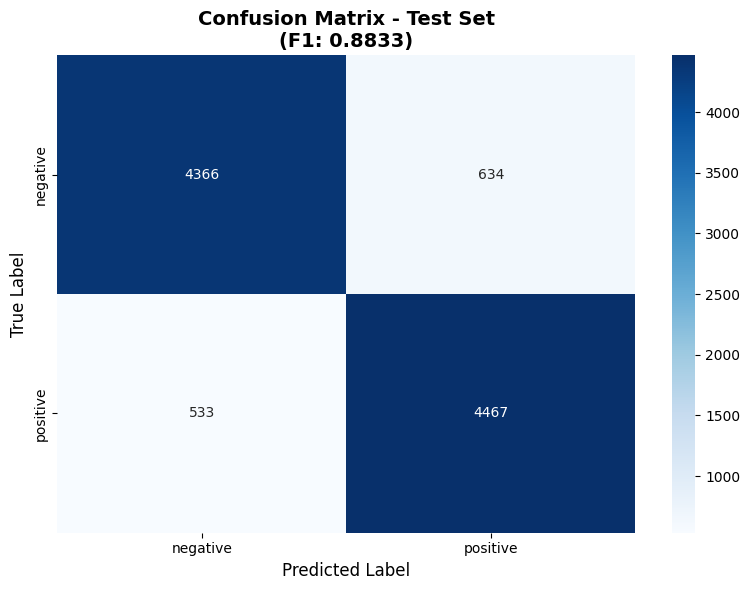


Confusion matrix saved: /kaggle/working/outputs_split/test_confusion_matrix.png


In [ ]:
print('\n' + '='*80)
print('ĐÁNH GIÁ CUỐI CÙNG TRÊN TEST SET (KHÔNG AUGMENT)')
print('='*80)

test_loss, test_f1, test_report, test_preds, test_labels = evaluate(model, test_loader, device)

print(f'\nTEST SET PERFORMANCE (KHÔNG AUGMENT - KHÁCH QUAN):')
print(f'   Loss: {test_loss:.4f}')
print(f'   Macro F1: {test_f1:.4f}')
print(f'\nClassification Report:')
print(test_report)

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[idx2label[str(i)] for i in range(num_classes)],
            yticklabels=[idx2label[str(i)] for i in range(num_classes)])
plt.title(f'Confusion Matrix - Test Set\n(F1: {test_f1:.4f})', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'test_confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f'\nConfusion matrix saved: {os.path.join(OUT_DIR, "test_confusion_matrix.png")}')
print('='*80)

## 3.15. Visualize Training History

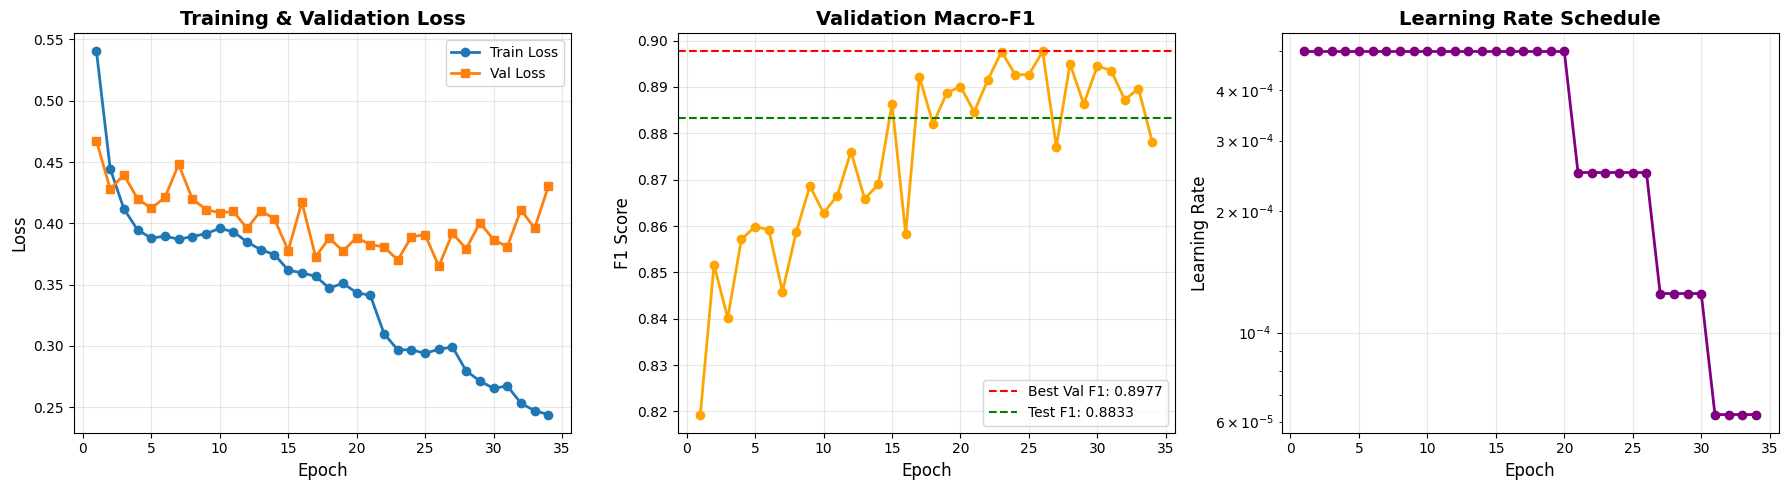


Training history saved: /kaggle/working/outputs_split/training_history.png


In [ ]:
if history:
    train_losses = [h['train_loss'] for h in history]
    val_losses = [h['val_loss'] for h in history]
    val_f1s = [h['val_macro_f1'] for h in history]
    lrs = [h['lr'] for h in history]
    epochs_range = range(1, len(history) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss
    axes[0].plot(epochs_range, train_losses, marker='o', label='Train Loss', linewidth=2)
    axes[0].plot(epochs_range, val_losses, marker='s', label='Val Loss', linewidth=2)
    axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # F1
    axes[1].plot(epochs_range, val_f1s, marker='o', color='orange', linewidth=2)
    axes[1].axhline(y=best_f1, color='r', linestyle='--', label=f'Best Val F1: {best_f1:.4f}')
    axes[1].axhline(y=test_f1, color='g', linestyle='--', label=f'Test F1: {test_f1:.4f}')
    axes[1].set_title('Validation Macro-F1', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('F1 Score', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[2].plot(epochs_range, lrs, marker='o', color='purple', linewidth=2)
    axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Learning Rate', fontsize=12)
    axes[2].set_yscale('log')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'training_history.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'\nTraining history saved: {os.path.join(OUT_DIR, "training_history.png")}')


## 3.16. Lưu Metadata

In [ ]:
model_meta = {
    'pad_idx': int(pad_idx),
    'unk_idx': 1,
    'vocab_size': int(vocab_size),
    'max_len': int(max_len),
    'embed_dim': EMBED_DIM,
    'hidden_dim': HIDDEN_DIM,
    'dropout': DROPOUT,
    'num_classes': int(num_classes),
    'best_val_macro_f1': float(best_f1),
    'test_macro_f1': float(test_f1),
    'test_loss': float(test_loss),
    'data_split_strategy': 'train_augmented_test_original',
    'train_augmented': True,
    'test_augmented': False,
    'no_data_leakage': True,
    'training_params': {
        'batch_size': BATCH_SIZE,
        'epochs': len(history),
        'learning_rate': LEARNING_RATE,
        'val_size': VAL_SIZE,
        'early_stop_patience': EARLY_STOP_PATIENCE,
        'seed': SEED
    },
    'data_info': {
        'total_train': len(train_seqs),
        'split_train': len(X_train),
        'split_val': len(X_val),
        'test': len(test_seqs),
        'source_data': DATA_DIR
    }
}

# Save as JSON
meta_json_path = os.path.join(OUT_DIR, 'meta.json')
with open(meta_json_path, 'w', encoding='utf-8') as f:
    json.dump(model_meta, f, indent=2, ensure_ascii=False)

# Save as npz
meta_npz_path = os.path.join(OUT_DIR, 'meta.npz')
np.savez(meta_npz_path, **model_meta)

print(f'\nMetadata saved:')
print(f'   {meta_json_path}')
print(f'   {meta_npz_path}')


Metadata saved:
   /kaggle/working/outputs_split/meta.json
   /kaggle/working/outputs_split/meta.npz


## 3.17. Tổng Kết

In [ ]:
print('\n' + '='*80)
print('HOÀN THÀNH TOÀN BỘ QUÁ TRÌNH!')
print('='*80)

print(f'\nTổng Kết:')
print(f'   Model: BiLSTM with multi-pooling')
print(f'   Parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'   Vocab size: {vocab_size:,}')
print(f'   Training epochs: {len(history)}')

print(f'\nPerformance:')
print(f'   Best Val F1: {best_f1:.4f}')
print(f'   Test F1: {test_f1:.4f} (KHÔNG AUGMENT - KHÁCH QUAN)')


print(f'\nOutput files trong {OUT_DIR}:')
for file in sorted(os.listdir(OUT_DIR)):
    file_path = os.path.join(OUT_DIR, file)
    if os.path.isfile(file_path):
        size_kb = os.path.getsize(file_path) / 1024
        print(f'   - {file:35s} ({size_kb:>8.1f} KB)')

print('\n' + '='*80)


HOÀN THÀNH TOÀN BỘ QUÁ TRÌNH!

Tổng Kết:
   Model: BiLSTM with multi-pooling
   Parameters: 13,856,258
   Vocab size: 50,002
   Training epochs: 34

Performance:
   Best Val F1: 0.8977
   Test F1: 0.8833 (KHÔNG AUGMENT - KHÁCH QUAN)

QUAN TRỌNG:
   Train set đã augment để tăng cường dữ liệu
   Test set GIỮ NGUYÊN - KHÔNG augment
   KHÔNG có data leakage
   Kết quả test phản ánh khả năng thực tế của model

Output files trong /kaggle/working/outputs_split:
   - best_model.pt                       (162390.6 KB)
   - meta.json                           (     0.7 KB)
   - meta.npz                            (     5.0 KB)
   - test_confusion_matrix.png           (    50.1 KB)
   - training_history.png                (   152.5 KB)

